## Imports

In [1]:
from rov import *
import matplotlib.pyplot as plt
import struct
import numpy as np
import polarTransform
from scapy.all import *
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.animation as animation

## Data loading

In [2]:
sonar_data = SonarData("../00-Data/14.07.23/01-Raw/SONAR-14.07.23-13.36.bin")
rov_location = LocationData("../00-Data/14.07.23/01-Raw/LOC-14.07.23-13.38.pcapng", nozeroes = True)

Initialized  ../00-Data/14.07.23/01-Raw/SONAR-14.07.23-13.36.bin  with  1193  packages in  1 m  4 s
Parsed  9027 / 18807  location packets.


## Video generation

In [3]:
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(0, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

In [11]:
def plot_scan(sonar_data: SonarData, location: LocationData, n, fig = None):

    angle = np.deg2rad(sonar_data.angles[-1] - sonar_data.angles[0])
    start_angle = 0.5* (np.pi - angle)
    end_angle = start_angle + angle
    image, _ = polarTransform.convertToCartesianImage(  np.rot90(sonar_data.sonar_array[n]),
                                                            finalRadius=1020,
                                                            initialAngle = start_angle,
                                                            finalAngle= end_angle,
                                                            order=4)

    t = sonar_data.sonar_times[n] - sonar_data.sonar_times[0]
    t_int = math.floor(t)
    h = t_int // 3600
    m = (t_int - h * 3600) // 60
    s = t_int - h * 3600 - m * 60
    ms = math.floor((t - t_int) * 1000)

    title_3d = ""
    pck_time = sonar_data.sonar_times[n]
    min_diff = 10**10
    t_id = -1
    for q in range(len(location.loc_times)):
        rot_time = location.loc_times[q]
        if abs(rot_time - pck_time) < min_diff:
            t_id = q
            min_diff = abs(rot_time - pck_time)

    if fig == None:
        fig = plt.figure(figsize=(13.2, 6))
    else:
        fig.clear()
    fig.add_subplot()
    ax = plt.subplot2grid(shape=(1, 5), loc=(0, 0), colspan=2)
    ax1 = plt.subplot2grid(shape=(1, 5), loc=(0, 2), colspan=3,projection='3d')
    ax2 = ax1.inset_axes([0, 0.8, 0.3, 0.3],projection='3d')
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax2.set_alpha(0.01)
    
    im = ax.imshow(np.flipud(image),vmin=0, vmax=255, cmap='hot')
    plt.colorbar(im,ax=ax)
    
    ax.set_yticks(np.linspace(0,image.shape[0],6))
    ax.set_yticklabels(np.linspace(sonar_data.range, 0,6).round(2))
    ax.set_ylabel('Range [m]')
    ax.set_xticks(np.linspace(0,image.shape[1],5))
    pix_res = sonar_data.range / image.shape[0]
    ax.set_xticklabels(np.linspace(-image.shape[1] * pix_res * 0.5, image.shape[1] * pix_res * 0.5,5).round(2))
    ax.set_title(rf'$t_{{{n}}} = $' + f"{m}m {s}s {ms}ms")

    # Pool location
    Xc,Yc,Zc = data_for_cylinder_along_z(0.2,0.37,3,1.2)
    
    
    ax1.set_zticks([1])
    ax1.set_xlabel('X [m]')
    ax1.set_ylabel('Y [m]')
    ax1.set_zlabel('Z [m]')
    ax1.elev = 50
    ax1.plot_surface(Xc, Yc, Zc, alpha=0.5)
    ax2.plot_surface(Xc, Yc, Zc, alpha=0.2)
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')
    ax2.elev = 0
    if min_diff >= 0.5:
        title_3d = "No location data"
    else:
        rot_x = location.rot_x[t_id]
        rot_y = location.rot_y[t_id]
        rot_z = location.rot_z[t_id]
        pos_x = location.x[t_id]
        pos_y = location.y[t_id]
        pos_z = location.z[t_id]
    
        offset_v = np.array([pos_x/1000,pos_y/1000,pos_z/1000])
        r = R.from_euler('xyz', [rot_x, rot_y, rot_z], degrees=True)
        tri_num = 10
        angle = np.deg2rad(sonar_data.angles[-1] - sonar_data.angles[0])
        start_angle = -0.5 * angle
        step = angle / tri_num
        ax2.scatter(offset_v[0], offset_v[1],offset_v[2],c='red')
        ax2.set_title('Pitch: ' + str(round(rot_y,2)) +'\u00b0', y=1.0, pad=-18)
        ax1.scatter(offset_v[0], offset_v[1],offset_v[2],c='red')
        for i in range(tri_num):
            x1 = np.cos(start_angle + step * i) * sonar_data.range
            y1 = np.sin(start_angle + step * i) * sonar_data.range
            z1 = 0.0
            
            v1 = np.array([x1, y1, z1])
            v1 = r.apply(v1)
            v1 += offset_v

            x2 = np.cos(start_angle + step * (i+1)) * sonar_data.range
            y2 = np.sin(start_angle + step * (i+1)) * sonar_data.range
            z2 = 0.0
            
            v2 = np.array([x2, y2, z2])
            v2 = r.apply(v2)
            v2 += offset_v

            v3 = offset_v
            collection = Poly3DCollection(np.stack([v1,v2,v3])[np.newaxis,:,:], alpha = 0.3, facecolor = 'r',linewidth=1)
            ax1.add_collection3d(collection)
            #-----
            ax2.add_collection3d(Poly3DCollection(np.stack([v1,v2,v3])[np.newaxis,:,:], alpha = 1, facecolor='r',edgecolor = 'r',linewidth=0.1))
    ax1.scatter3D([0.479],[0.257],[0.036],) # Object location
    ax1.set_title(title_3d)

    # -------

    if fig == None:
        plt.tight_layout()
        plt.show()

/tmp/ipykernel_220166/674279500.py:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot2grid(shape=(1, 5), loc=(0, 0), colspan=2)


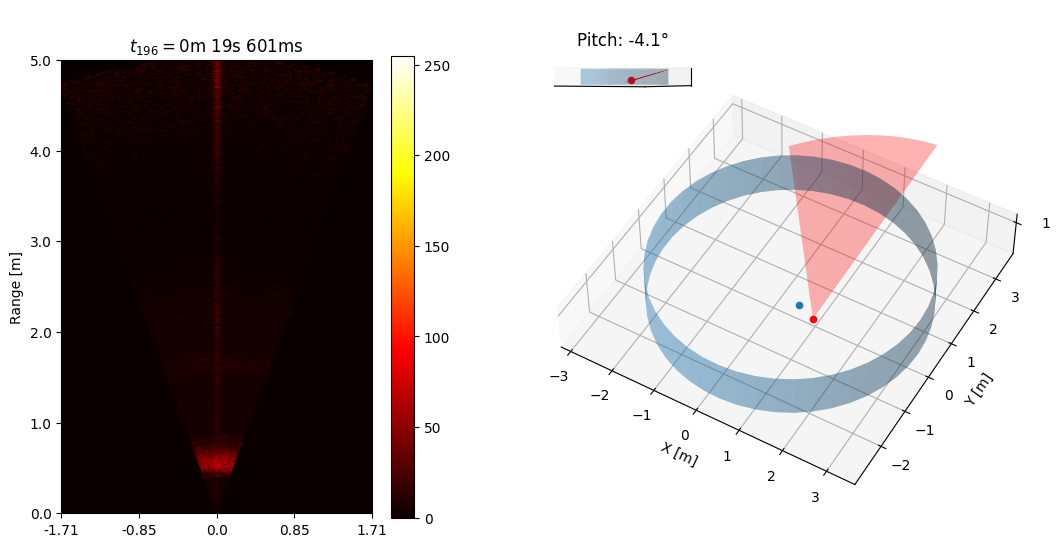

In [12]:
# Plotting single frame
plot_scan(sonar_data, rov_location, 196)

/tmp/ipykernel_220166/674279500.py:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot2grid(shape=(1, 5), loc=(0, 0), colspan=2)


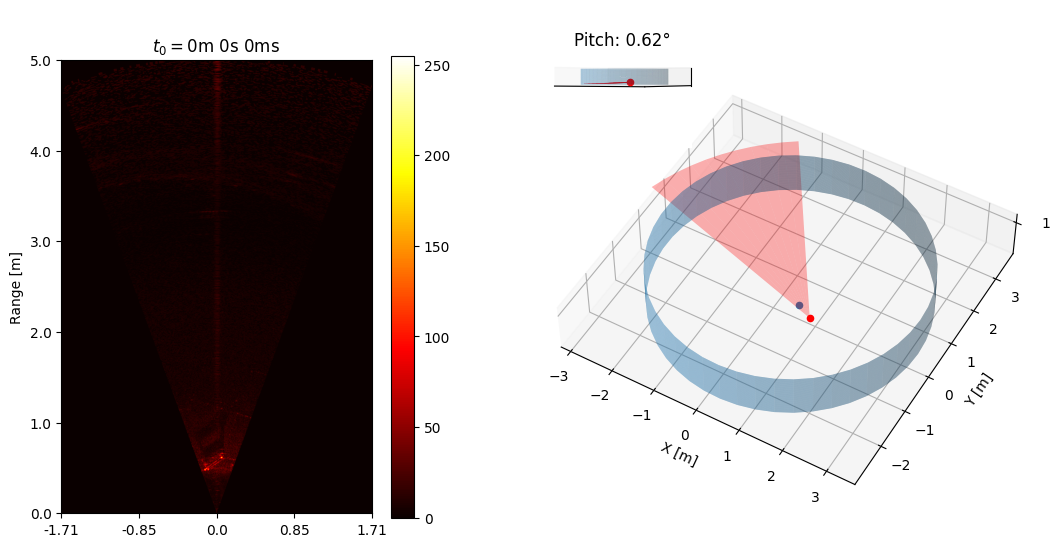

In [7]:
fig = plt.figure(figsize=(13.2, 6))

def animate(i):
    plot_scan(sonar_data, rov_location, i, fig)

ani = animation.FuncAnimation(fig, animate, interval=100, frames=sonar_data.pck_num)

f = r"../00-Data/14.07.23/02-Processed/VID-14.07.23-13.36.mp4" 
writervideo = animation.FFMpegWriter(fps=10) 
ani.save(f, writer=writervideo)